**Домашнее задание №2** - Латентное пространство в VAE автоенкодере

Прочитайте внимательно статью "Variational Autoencoders are Beautiful":

https://www.compthree.com/blog/autoencoder/

В данном задании необходимо:

1) реализовать VAE автоенкодер с архитектурой как на рисунке:
<img src='mnist_vae.png' width=500>

2) Обучить его на обучающей выборке из базы данных MNIST и после этого, воспользоваться энкодером, чтобы преобразовать картинки из тестовой выборки в латентное пространство и получить рисунок похожий на рисунок ниже:
<img src='vae_mnist_cloud.png' width=500>

3) Наконец, построить в латентном пространстве на квадрате [-2, 2]x[-2, 2] сетку из 15x15 значений и построить с помощью декодера картинки цифр для каждого значения из этой сетки и получить рисунок похожий на рисунок ниже:
<img src='vae_mnist_digits.png' width=500>

Для реализации VAE автоенкодера воспользуйтесь кодом ниже:

In [2]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import transforms
from torchvision.utils import save_image


# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Create a directory if not exists
sample_dir = 'samples'
if not os.path.exists(sample_dir):
    os.makedirs(sample_dir)

# Hyper-parameters
image_size = 784
h_dim = 500
h2_dim = 250
z_dim = 2
num_epochs = 15
batch_size = 128
learning_rate = 1e-3

# MNIST dataset
dataset = torchvision.datasets.MNIST(root='../../data',
                                     train=True,
                                     transform=transforms.ToTensor(),
                                     download=True)

# Data loader
data_loader = torch.utils.data.DataLoader(dataset=dataset,
                                          batch_size=batch_size, 
                                          shuffle=True)


# VAE model
class VAE(nn.Module):
    def __init__(self, image_size=784, h_dim=500, h2_dim = 250, z_dim=2):
        super(VAE, self).__init__()
        self.fc1 = nn.Linear(image_size, h_dim)
        self.fc2 = nn.Linear(h_dim, h2_dim)
        self.fc3 = nn.Linear(h2_dim, z_dim)
        self.fc4 = nn.Linear(h2_dim,z_dim)
        self.fc5 = nn.Linear(z_dim, h2_dim)
        self.fc6 = nn.Linear(h2_dim, h_dim)
        self.fc7 = nn.Linear(h_dim,image_size)
        
    def encode(self, x):
        h = F.relu(self.fc1(x))
        h = F.relu(self.fc2(h))
        return self.fc3(h), self.fc4(h)
    
    def reparameterize(self, mu, log_var):
        std = torch.exp(log_var/2)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        h = F.relu(self.fc5(z))
        h = F.relu(self.fc6(h))
        return F.sigmoid(self.fc7(h))
    
    def forward(self, x):
        mu, log_var = self.encode(x)
        z = self.reparameterize(mu, log_var)
        x_reconst = self.decode(z)
        return x_reconst, mu, log_var

model = VAE(z_dim=z_dim).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Start training
for epoch in range(num_epochs):
    for i, (x, _) in enumerate(data_loader):
        # Forward pass
        x = x.to(device).view(-1, image_size)
        x_reconst, mu, log_var = model(x)
        
        # Compute reconstruction loss and kl divergence
        # For KL divergence, see Appendix B in VAE paper or http://yunjey47.tistory.com/43
        reconst_loss = F.binary_cross_entropy(x_reconst, x, size_average=False)
        kl_div = - 0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
        
        # Backprop and optimize
        loss = reconst_loss + kl_div
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if (i+1) % 10 == 0:
            print ("Epoch[{}/{}], Step [{}/{}], Reconst Loss: {:.4f}, KL Div: {:.4f}" 
                   .format(epoch+1, num_epochs, i+1, len(data_loader), reconst_loss.item(), kl_div.item()))
    
    with torch.no_grad():
        # Save the sampled images
        z = torch.randn(batch_size, z_dim).to(device)
        out = model.decode(z).view(-1, 1, 28, 28)
        save_image(out, os.path.join(sample_dir, 'sampled-{}.png'.format(epoch+1)))

        # Save the reconstructed images
        out, _, _ = model(x)
        x_concat = torch.cat([x.view(-1, 1, 28, 28), out.view(-1, 1, 28, 28)], dim=3)
        save_image(x_concat, os.path.join(sample_dir, 'reconst-{}.png'.format(epoch+1)))

/Users/usersda/opt/anaconda3/lib/python3.9/site-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/Users/usersda/opt/anaconda3/lib/python3.9/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


Epoch[1/15], Step [10/469], Reconst Loss: 36803.5078, KL Div: 970.8959
Epoch[1/15], Step [20/469], Reconst Loss: 28192.2734, KL Div: 99.2958
Epoch[1/15], Step [30/469], Reconst Loss: 27384.9219, KL Div: 86.4647
Epoch[1/15], Step [40/469], Reconst Loss: 26030.0391, KL Div: 252.9173
Epoch[1/15], Step [50/469], Reconst Loss: 26819.5859, KL Div: 185.5391
Epoch[1/15], Step [60/469], Reconst Loss: 26079.5508, KL Div: 213.0022
Epoch[1/15], Step [70/469], Reconst Loss: 26367.5137, KL Div: 287.3541
Epoch[1/15], Step [80/469], Reconst Loss: 23206.9375, KL Div: 347.0221
Epoch[1/15], Step [90/469], Reconst Loss: 24538.4609, KL Div: 306.6688
Epoch[1/15], Step [100/469], Reconst Loss: 23780.7539, KL Div: 388.6289
Epoch[1/15], Step [110/469], Reconst Loss: 22408.7344, KL Div: 477.1734
Epoch[1/15], Step [120/469], Reconst Loss: 22505.5234, KL Div: 449.9035
Epoch[1/15], Step [130/469], Reconst Loss: 22540.3086, KL Div: 474.5906
Epoch[1/15], Step [140/469], Reconst Loss: 21859.8672, KL Div: 544.0101
Epo

Epoch[3/15], Step [240/469], Reconst Loss: 17988.3125, KL Div: 733.1006
Epoch[3/15], Step [250/469], Reconst Loss: 18874.1719, KL Div: 773.0601
Epoch[3/15], Step [260/469], Reconst Loss: 19565.4590, KL Div: 713.1137
Epoch[3/15], Step [270/469], Reconst Loss: 18499.1152, KL Div: 734.6164
Epoch[3/15], Step [280/469], Reconst Loss: 19061.5156, KL Div: 725.5768
Epoch[3/15], Step [290/469], Reconst Loss: 18468.1016, KL Div: 753.1923
Epoch[3/15], Step [300/469], Reconst Loss: 19269.7461, KL Div: 743.2854
Epoch[3/15], Step [310/469], Reconst Loss: 19381.5156, KL Div: 771.3309
Epoch[3/15], Step [320/469], Reconst Loss: 18858.0664, KL Div: 733.0233
Epoch[3/15], Step [330/469], Reconst Loss: 20177.5078, KL Div: 706.6663
Epoch[3/15], Step [340/469], Reconst Loss: 18880.6680, KL Div: 793.7139
Epoch[3/15], Step [350/469], Reconst Loss: 20124.7285, KL Div: 708.6307
Epoch[3/15], Step [360/469], Reconst Loss: 19671.4102, KL Div: 758.1643
Epoch[3/15], Step [370/469], Reconst Loss: 18811.8223, KL Div: 7

Epoch[6/15], Step [10/469], Reconst Loss: 18811.6055, KL Div: 816.7394
Epoch[6/15], Step [20/469], Reconst Loss: 17474.7656, KL Div: 809.6574
Epoch[6/15], Step [30/469], Reconst Loss: 17613.0215, KL Div: 764.7588
Epoch[6/15], Step [40/469], Reconst Loss: 18639.4492, KL Div: 766.4774
Epoch[6/15], Step [50/469], Reconst Loss: 18421.1309, KL Div: 799.5508
Epoch[6/15], Step [60/469], Reconst Loss: 19188.7988, KL Div: 798.0149
Epoch[6/15], Step [70/469], Reconst Loss: 18286.2461, KL Div: 769.0352
Epoch[6/15], Step [80/469], Reconst Loss: 18023.3125, KL Div: 786.6093
Epoch[6/15], Step [90/469], Reconst Loss: 18522.1523, KL Div: 773.1075
Epoch[6/15], Step [100/469], Reconst Loss: 17822.1992, KL Div: 774.7017
Epoch[6/15], Step [110/469], Reconst Loss: 18684.5000, KL Div: 771.6238
Epoch[6/15], Step [120/469], Reconst Loss: 18638.4180, KL Div: 759.8552
Epoch[6/15], Step [130/469], Reconst Loss: 17947.3809, KL Div: 791.0676
Epoch[6/15], Step [140/469], Reconst Loss: 18510.9902, KL Div: 798.8052
E

Epoch[8/15], Step [240/469], Reconst Loss: 17616.3262, KL Div: 797.1854
Epoch[8/15], Step [250/469], Reconst Loss: 17124.9023, KL Div: 784.4047
Epoch[8/15], Step [260/469], Reconst Loss: 16628.3359, KL Div: 855.7351
Epoch[8/15], Step [270/469], Reconst Loss: 18191.9258, KL Div: 796.4783
Epoch[8/15], Step [280/469], Reconst Loss: 17062.7656, KL Div: 828.9543
Epoch[8/15], Step [290/469], Reconst Loss: 17763.6270, KL Div: 813.9343
Epoch[8/15], Step [300/469], Reconst Loss: 18010.0625, KL Div: 820.8870
Epoch[8/15], Step [310/469], Reconst Loss: 17746.5371, KL Div: 836.7974
Epoch[8/15], Step [320/469], Reconst Loss: 18086.1055, KL Div: 809.4570
Epoch[8/15], Step [330/469], Reconst Loss: 16626.6992, KL Div: 832.5736
Epoch[8/15], Step [340/469], Reconst Loss: 17933.6562, KL Div: 799.0377
Epoch[8/15], Step [350/469], Reconst Loss: 18168.9648, KL Div: 800.1787
Epoch[8/15], Step [360/469], Reconst Loss: 18155.6797, KL Div: 828.1699
Epoch[8/15], Step [370/469], Reconst Loss: 17506.9844, KL Div: 7

Epoch[10/15], Step [460/469], Reconst Loss: 16641.9180, KL Div: 821.8019
Epoch[11/15], Step [10/469], Reconst Loss: 16702.0820, KL Div: 827.1052
Epoch[11/15], Step [20/469], Reconst Loss: 17808.2578, KL Div: 832.6444
Epoch[11/15], Step [30/469], Reconst Loss: 17408.4492, KL Div: 831.6749
Epoch[11/15], Step [40/469], Reconst Loss: 16917.3203, KL Div: 820.1511
Epoch[11/15], Step [50/469], Reconst Loss: 17197.7148, KL Div: 824.3174
Epoch[11/15], Step [60/469], Reconst Loss: 17038.4219, KL Div: 866.1193
Epoch[11/15], Step [70/469], Reconst Loss: 16897.9844, KL Div: 833.0237
Epoch[11/15], Step [80/469], Reconst Loss: 17468.4121, KL Div: 850.3263
Epoch[11/15], Step [90/469], Reconst Loss: 16713.8477, KL Div: 821.7326
Epoch[11/15], Step [100/469], Reconst Loss: 17441.9863, KL Div: 825.2434
Epoch[11/15], Step [110/469], Reconst Loss: 17097.3867, KL Div: 838.4548
Epoch[11/15], Step [120/469], Reconst Loss: 17230.4707, KL Div: 824.7512
Epoch[11/15], Step [130/469], Reconst Loss: 17981.8086, KL D

Epoch[13/15], Step [210/469], Reconst Loss: 16965.2598, KL Div: 872.8384
Epoch[13/15], Step [220/469], Reconst Loss: 17496.9297, KL Div: 848.4739
Epoch[13/15], Step [230/469], Reconst Loss: 17207.2715, KL Div: 837.0493
Epoch[13/15], Step [240/469], Reconst Loss: 17564.4102, KL Div: 825.1897
Epoch[13/15], Step [250/469], Reconst Loss: 17223.8926, KL Div: 863.0705
Epoch[13/15], Step [260/469], Reconst Loss: 17482.0625, KL Div: 857.0298
Epoch[13/15], Step [270/469], Reconst Loss: 16903.9277, KL Div: 835.5131
Epoch[13/15], Step [280/469], Reconst Loss: 17222.1426, KL Div: 821.5082
Epoch[13/15], Step [290/469], Reconst Loss: 17858.7324, KL Div: 834.8566
Epoch[13/15], Step [300/469], Reconst Loss: 16945.2695, KL Div: 830.6042
Epoch[13/15], Step [310/469], Reconst Loss: 18095.5996, KL Div: 843.7404
Epoch[13/15], Step [320/469], Reconst Loss: 16901.7715, KL Div: 824.1292
Epoch[13/15], Step [330/469], Reconst Loss: 18744.6152, KL Div: 836.7121
Epoch[13/15], Step [340/469], Reconst Loss: 17095.3

Epoch[15/15], Step [420/469], Reconst Loss: 17203.5352, KL Div: 835.4704
Epoch[15/15], Step [430/469], Reconst Loss: 17237.4141, KL Div: 830.3867
Epoch[15/15], Step [440/469], Reconst Loss: 17056.3145, KL Div: 843.8770
Epoch[15/15], Step [450/469], Reconst Loss: 16862.8906, KL Div: 848.5483
Epoch[15/15], Step [460/469], Reconst Loss: 17392.6641, KL Div: 834.1860


<AxesSubplot:>

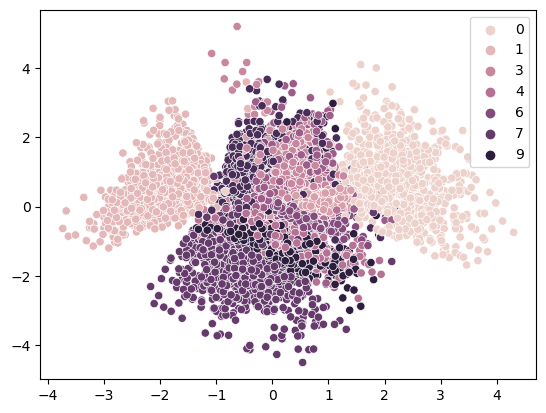

In [18]:
import numpy as np
import seaborn as sns

dataset = torchvision.datasets.MNIST(root='../../data',
                                     train=True,
                                     transform=transforms.ToTensor(),
                                     download=True)

batch_size = 10000
test_data_loader = torch.utils.data.DataLoader(dataset=dataset, batch_size=batch_size,
                                          shuffle=True)

# for i, (x, y) in enumerate(test_data_loader):
(x,y)=next(iter(test_data_loader))
x = x.view(-1, image_size)
mu, log_var = model.encode(x)
z = model.reparameterize(mu, log_var)
z = z.to(device).detach().numpy()
sns.scatterplot(x = z[:, 0], y = z[:, 1], hue = y)

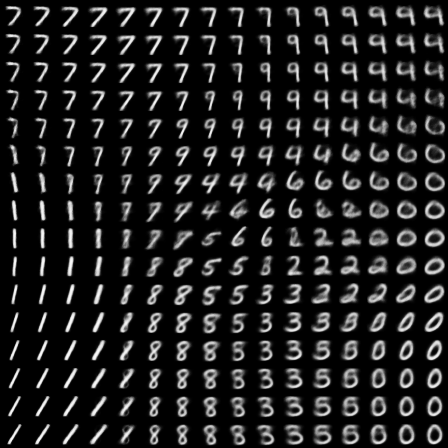

In [34]:
import numpy as np

values = np.arange(-2, 2, .25)
xx, yy = np.meshgrid(values, values)

cont=torch.zeros([1, 28 * len(values), 28 * len(values)])
transf2 = transforms.ToPILImage()
z = torch.zeros([1, 1, 2])


for row in range(xx.shape[0]):
    for col in range(xx.shape[1]):
        z[0, 0, 0]=xx[row, col]
        z[0, 0, 1]=yy[row, col]
        temp = torch.reshape(model.decode(z), [1, 28, 28])
        cont[0, row * 28:(row + 1) * 28, col * 28:(col + 1) * 28]=temp 
new_image = transf2(cont)
new_image